In [1]:
# core scientific libraries
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import datetime

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# secondary libraries
import netCDF4 as nc
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, interplevel, CoordPair, vertcross, g_uvmet, interpline, destagger,
                interp2dxy, ll_to_xy, xy, ALL_TIMES, vinterp)
import metpy.calc as mpcalc
from metpy.units import units

import pytz

from xarray.backends.netCDF4_ import NetCDF4DataStore

import copy 

In [2]:
def plot_cross_section(data, pot_data, terrian, levels_data, levels_pot, data_cols, data_units, data_title, \
                       data_name, outdir, lines_lat, lines_col, y_max, mnt_labels, mnt_labs_pos):
    ''' plot cross section'''
    
    # save vertical and horizontal coordinates
    vert = data['z'].sel(z = slice(0, y_max))
    hor = data['lat']
    
    # Start Figure
    fig = plt.figure(figsize=(12, 6))

    # Specify plotting axis (single panel)
    ax = plt.subplot(111)

    cf = ax.contourf(hor, vert, data.sel(z = slice(0, y_max))[:,:,0].values, cmap = data_cols, \
                         extend = 'both', levels = levels_data)

    # Theta contours 
    theta_contours = ax.contour(hor, vert, pot_data.sel(z = slice(0, y_max))[:,:,0].values, colors = 'k', levels = levels_pot)

    plt.clabel(theta_contours, fmt='%d',fontsize=8.5, inline_spacing=5, inline = 1)

    ct = ax.fill_between(hor, 0, terrian[:,0].values, facecolor = "silver")

    cb = plt.colorbar(cf, ax=ax, label = data_units)
    
    ax.set_xlabel("Latitude along Longitude " + str(data['lon'][0].values), fontsize=12)
    ax.set_ylabel("Height (m)", fontsize=12)
    
    # add labels for SYM and SRM
    props = dict(facecolor='silver', edgecolor = 'silver')
    
    if (mnt_labels == True):
        # add labels for SYM and SRM
        props = dict(facecolor='silver', edgecolor = 'silver')

        ax.text(mnt_labs_pos[0], mnt_labs_pos[1], 'SYM', fontsize = 15, transform = ax.transAxes, bbox = props)
        ax.text(mnt_labs_pos[2], mnt_labs_pos[3], 'SRM', fontsize = 15, transform = ax.transAxes, bbox = props) 
    
    n_lines = len(lines_lat)
    
    for i in range(n_lines):
        plt.plot([lines_lat[i], lines_lat[i]], [0,y_max] , color = lines_col[i], linestyle = 'dashed')
    
    # Make title of datatime and second title for date time
    plt.title(data_title)
    plt.title(str(data['time'].values)[:16].replace('T',' ') + ' PDT', loc = 'right')
    
    # Display figure
    # save file name as start datetime end datetime and variable
    plot_name = data_name + '_' \
            + str(data['time'].values)[:13].replace('/','_').replace(' ','_').replace('T','_').replace('-','_') + \
                '.png'

    plt.savefig(outdir+plot_name,  bbox_inches='tight', dpi = 120)
    plt.show()
    print('File saved as:', outdir+plot_name, '\n')

In [3]:
# Set filepath
#Duine 2019 non fire western case study 
# datdir = '/home/sbarc/wrf/wrf401/sundowners/20170311/run-64452560-z0-SMOIS200/'
# filename = 'wrfout_d04_2017-03-10_18:00:00'

# Non-sundowner
datdir = '../input_data/'
filename = 'wrfout_d03_2017-05-22_00:00:00'

# #Cannon Case Study Non-sundowner
# datdir = '/home/sundowners/non-sundowner/2004/'
# filename = 'wrfout_d04_2004-04-29_00:00:00'

# set output filepath
outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/'
fig_outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/'
dat_outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/data/'


# open wrf Dataset object
filepath = datdir + filename
print('Opened File:', filepath, '\n')

# Open NetCDF Dataset object
data = xr.open_dataset(filepath)

Opened File: ../input_data/wrfout_d03_2017-05-22_00:00:00 



In [4]:
data

<xarray.Dataset>
Dimensions:   (Time: 24, lat: 135, lon: 156, z: 420)
Coordinates:
    lon_grid  (lat, lon) float32 ...
    lat_grid  (lat, lon) float32 ...
    time      (Time) datetime64[ns] ...
  * z         (z) float64 0.0 50.0 100.0 150.0 ... 2.085e+04 2.09e+04 2.095e+04
  * lat       (lat) float32 33.110657 33.12887 33.147068 ... 35.54185 35.560207
  * lon       (lon) float32 -121.78293 -121.7612 ... -118.43443 -118.41269
Dimensions without coordinates: Time
Data variables:
    temp      (Time, z, lat, lon) float32 ...
    theta     (Time, z, lat, lon) float32 ...
    ua        (Time, z, lat, lon) float32 ...
    va        (Time, z, lat, lon) float32 ...
    wa        (Time, z, lat, lon) float32 ...
    rh        (Time, z, lat, lon) float32 ...
    terr      (lat, lon) float32 ...

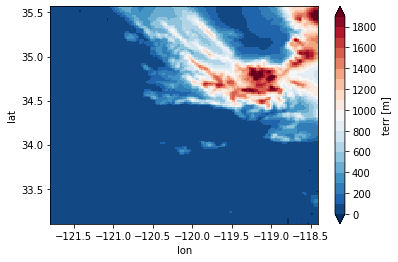

In [5]:
data['terr'].plot(levels = np.arange(0, 2000, 100))

In [37]:
# choose cross section starting and ending lat and lons
cross_lats = [34.9, 33.9]
cross_lons = [-119.65, -119.66] # must only include one longitude point

# save thetas, vertical velocities, topo heights, and pbl height through the cross section
cross_data = data.sel(lat = slice(cross_lats[1], cross_lats[0]), 
                     lon = slice(cross_lons[1], cross_lons[0]))

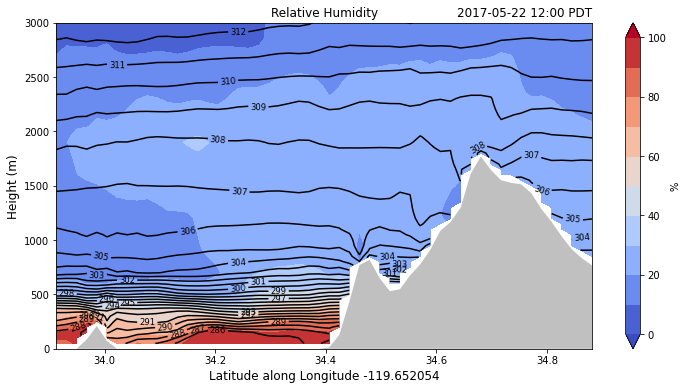

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/relative_humidity_2017_05_22_12.png 



In [40]:
# specify timestep
timestep = 12

# specify location of SYM and SRM labels and if you want them
labs_pos = [0.24, 0.1, 0.44, 0.35]
lab_key = False

# choose variable
var_no = 2
varz = ['va', 'wa', 'rh']
var_units = [ "m s-1", "m s-1", "%"]
var_names = ['merd_velocity', 'vertical_velocity', 'relative_humidity']
var_titles = ['Meridional Velocity', 'Vertical Velocity', 'Relative Humidity']

var_colors = ['PuOr', 'PuOr', 'coolwarm']
var_levels = [np.arange(-20, 21, 1), np.arange(-4, 5, 1), np.arange(0, 110, 10)]

var = varz[var_no]
var_unit = var_units[var_no]

var_name = var_names[var_no]
var_title = var_titles[var_no]
var_color = var_colors[var_no]
levels = var_levels[var_no]

# choose colorbar levels for theta
dmax = np.ceil(np.nanmax(data['theta'].values))
dmin = np.floor(np.nanmin(data['theta'].values))
levelst = np.arange(dmin, dmax + 1, 1)
    
plot_cross_section(cross_data[var].sel(Time = timestep), \
                   cross_data['theta'].sel(Time = timestep), \
                   cross_data['terr'], levels, levelst, var_color, var_unit, \
                    var_title, var_name, fig_outdir, [], [], 3000, lab_key, labs_pos)